# Задание
Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

ДЗ из первой лекции ниже

In [288]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox

In [289]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [290]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        
    return

In [291]:
#Исходный датафрейм
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


D:\Program_Files\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


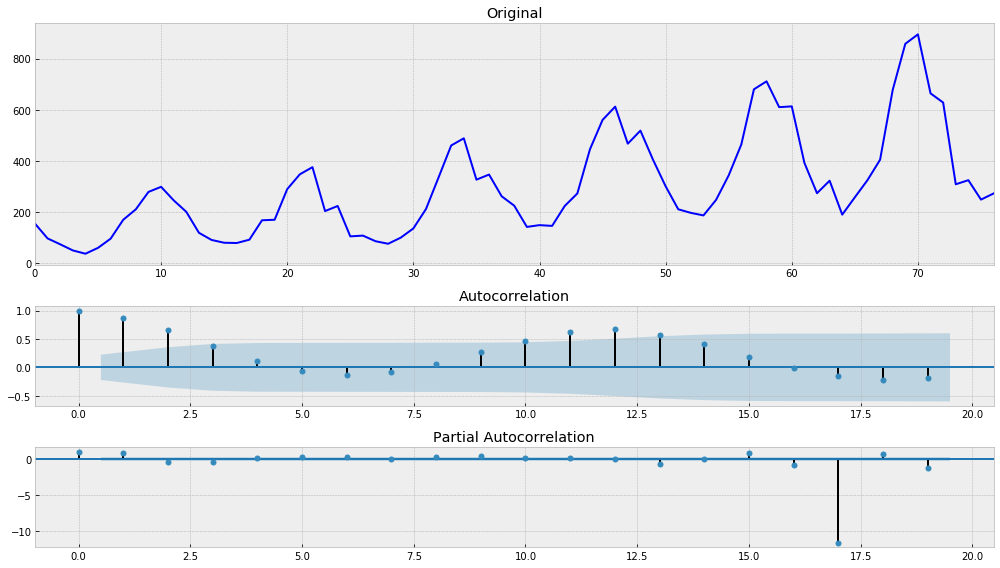

In [292]:
tsplot(series)

In [293]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


D:\Program_Files\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


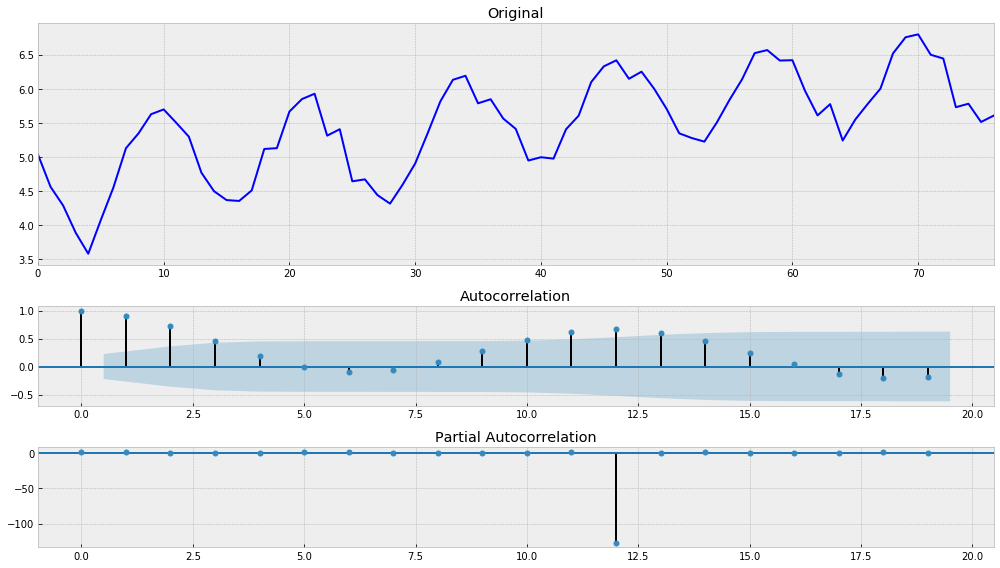

In [294]:
tsplot(series)

In [295]:
series_dif = np.diff(series, 3)

Results of Dickey-Fuller Test:
Test Statistic                -7.398495e+00
p-value                        7.665079e-11
#Lags Used                     1.200000e+01
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


D:\Program_Files\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


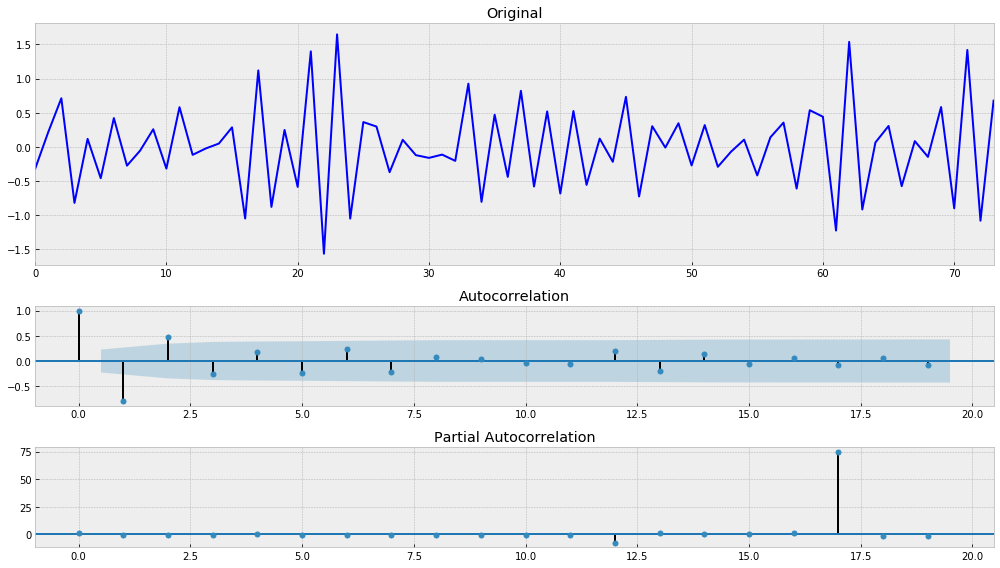

In [296]:
tsplot(series_dif)

Results of Dickey-Fuller Test:
Test Statistic                -7.398495e+00
p-value                        7.665079e-11
#Lags Used                     1.200000e+01
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


D:\Program_Files\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


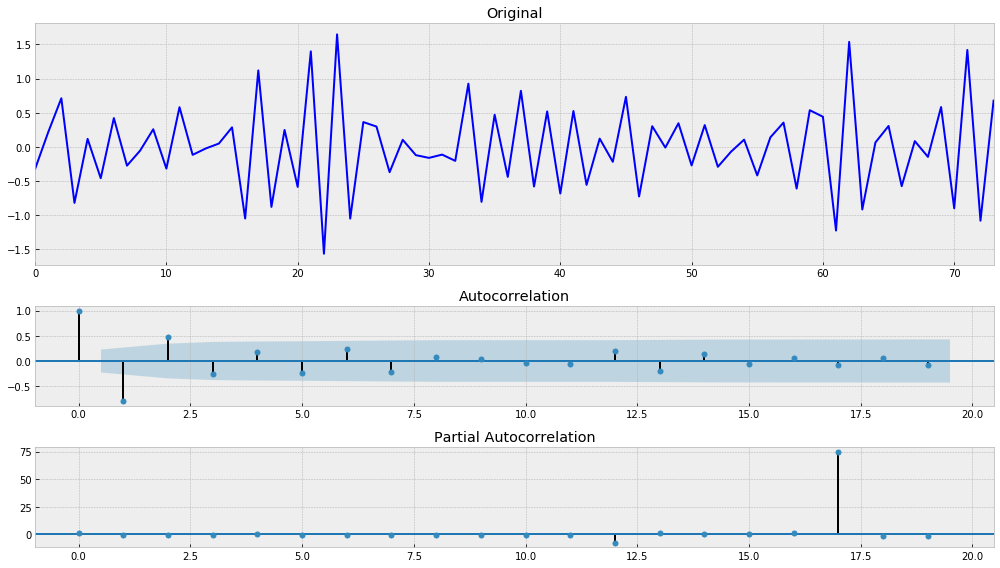

In [297]:
series_dif = np.diff(series, 3)
tsplot(series_dif)

## ДЗ 2 начинается ниже

### Скользящее среднее

In [298]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        
    return series.rolling(n).mean()

#### Исходный ряд

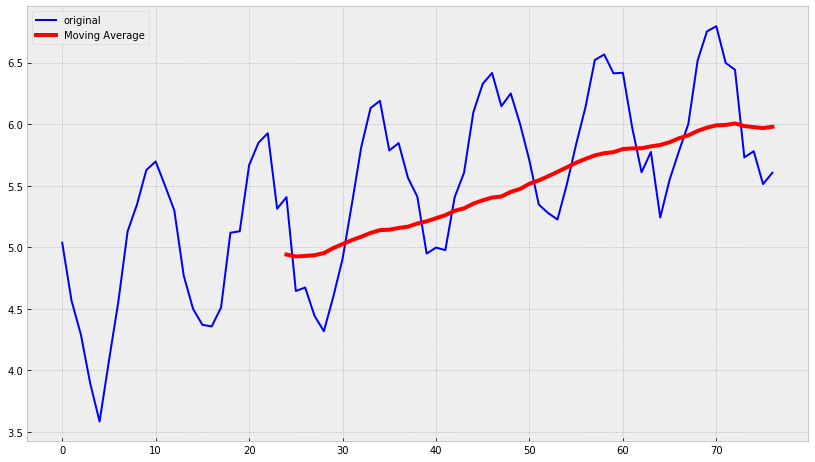

In [299]:
#Исходный ряд
ser = moving_average(series, 25)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Интересно, что при ширене окна 2 график скользящего среднего очеь точно поворяет график ряда.
На графике явно виден восходящий тренд.

#### Дифференцирвоанный ряд

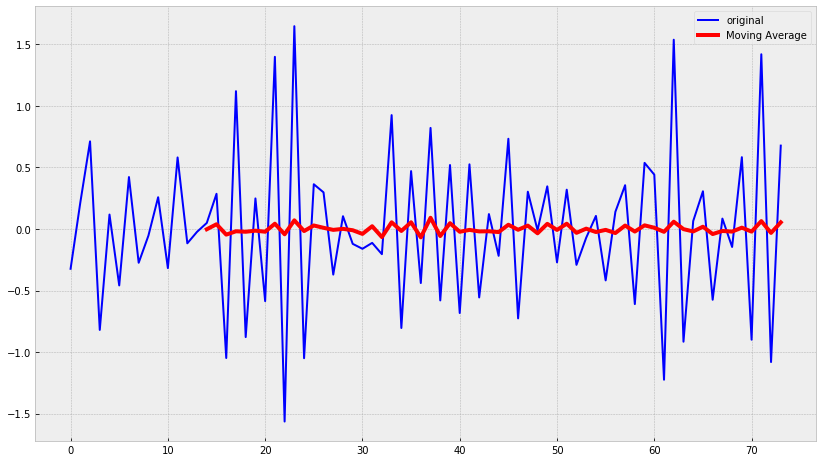

In [300]:
#Диффиренцированный ряд
ser = moving_average(series_dif, 15)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_dif, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Уже после ширины окна >15 график скользвщей средней меняется не сильно и выглядит как колебания около оси, что, наверное, можно объяснить результатом диффиренцирования - убрали тренд.

### Взвешенное скользящие среднее

In [301]:
# функция вычисления n первых чисел ряа Фиббоначи
def fib(n):
    a = 0
    b = 1
    sumf = []
    for __ in range(n):
        a, b = b, a + b
        sumf.append(a)
        
    return sumf

In [302]:
# Я доработал функцию, что бы было удобнее "играть" параметрами: ширина окна и веса
def weighted_moving_average(series, n):
    weights = fib(n)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

#### Исходный ряд

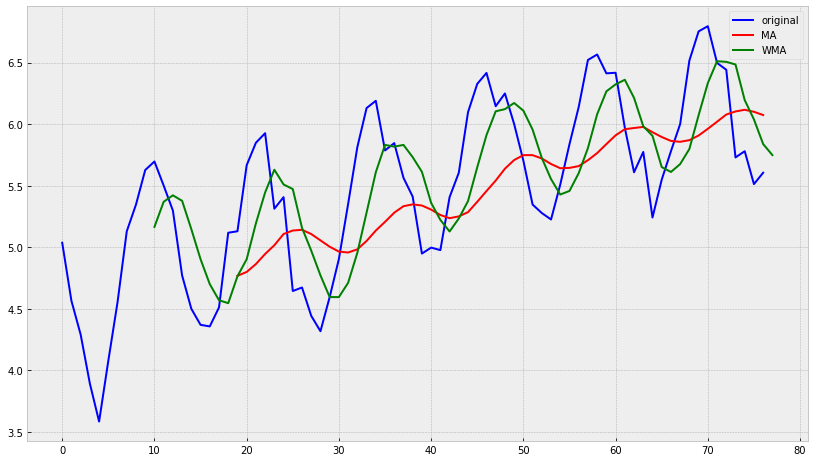

In [303]:
wma = weighted_moving_average(series, 10)
ma = moving_average(series, 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

#### Дифференцирвоанный ряд

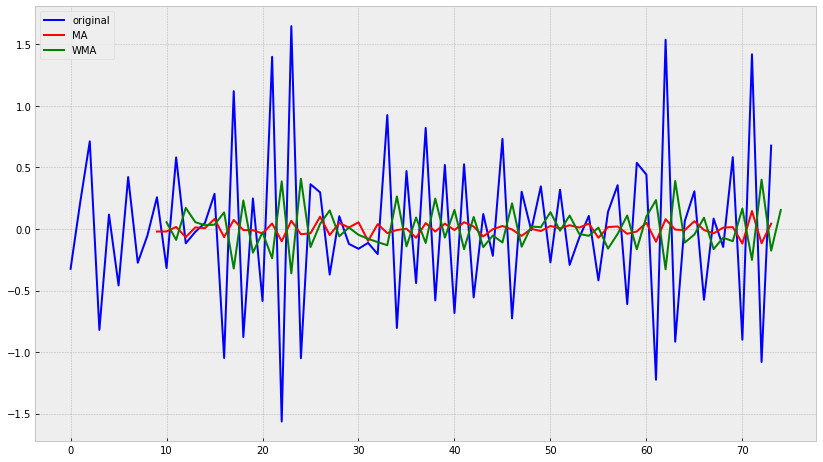

In [304]:
wma = weighted_moving_average(series_dif, 10)
ma = moving_average(series_dif, 10)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_dif, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Видно, что при меньшем ширене окна у WMA, чем у МА тренд прослеживается лучше и точнее, поскольку учитывается предыдущая история.

### Экспоненциальное сглаживание

In [305]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        
    return pd.Series(result)

#### Исходный ряд

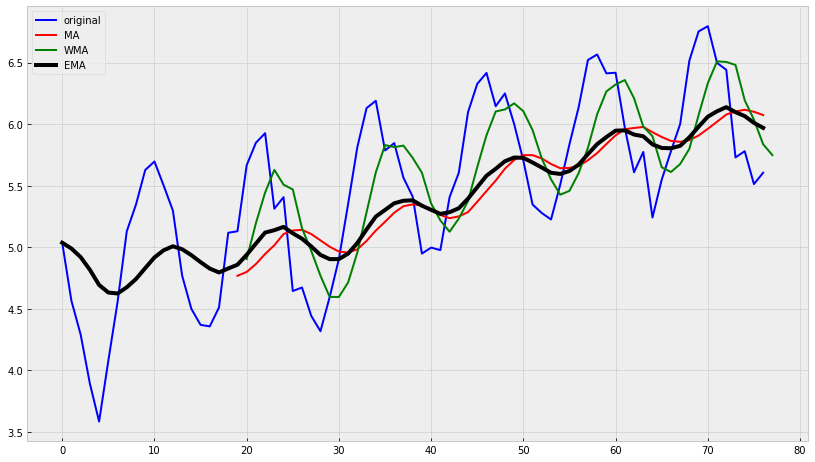

In [306]:
alf = .1 #коэффициент альфа
w_w =20 #ширина окна
ema = exponential_moving_average(series, alf)
wma = weighted_moving_average(series, w_w)
ma = moving_average(series, w_w)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

#### Дифференцирвоанный ряд

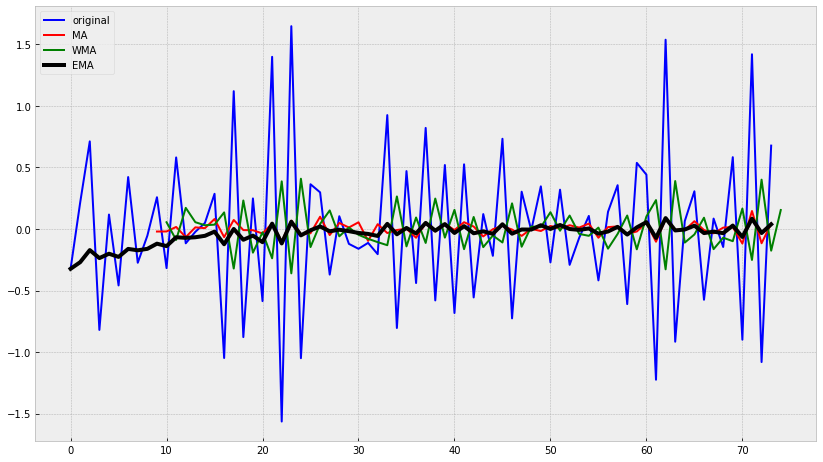

In [307]:
alf = .1 #коэффициент альфа
w_w = 10 #ширина окна
ema = exponential_moving_average(series_dif, alf)
wma = weighted_moving_average(series_dif, w_w)
ma = moving_average(series_dif, w_w)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_dif, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Экспоненциальное сглаживание, в отличие от MA и WMA, начинается от начала ряда и так же хорошо показывает тренд как МА, но мы в при его использованиии не треяем информацию, и тренде в начале ряда.

### Двойное экспоненциальное сглаживание

#### Исходный ряд

In [308]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    return pd.Series(result)

In [309]:
def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

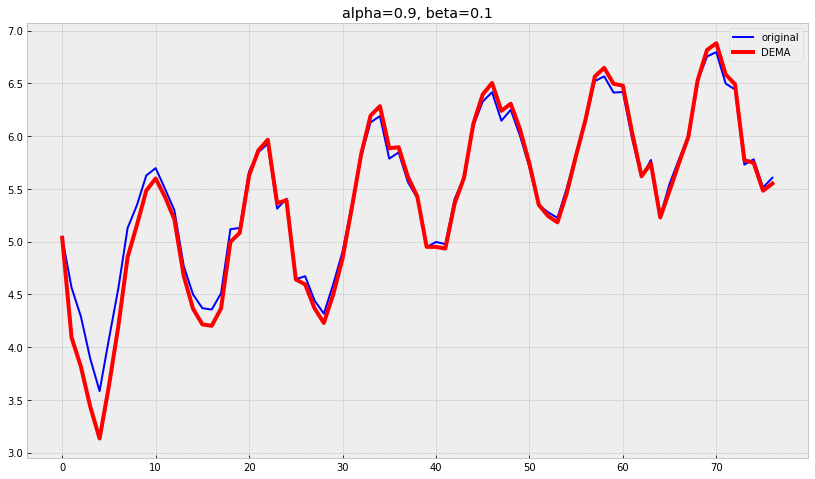

In [310]:
plot_dema(series, 0.9, 0.1)

Наблюдения:
1) при занчениях стремящихся к (0.9, 0.1) график dema стремиться к графику ряда;
2) при малых значениях альфа и бетта, граффик уже ничем не напоминает график исходного ряда;
3) при больших значениях коэффициентов, график очень походит на график ряда, однако есть заметное оставание и большая амплитуда (особенно заметно это около середины диапазона.

#### Дифференцированный ряд

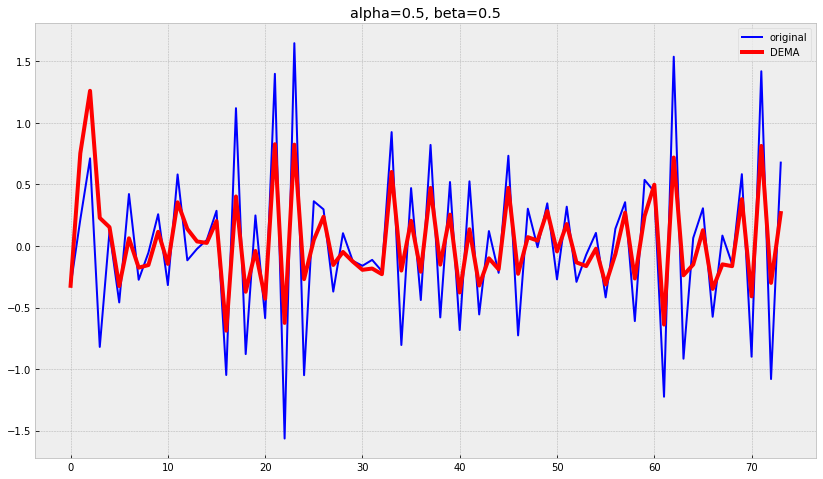

In [311]:
plot_dema(series_dif, 0.5, 0.5)

Наблюдения:
1) при занчениях стремящихся к (0.9, 0.9) график dema стремиться к графику ряда, тем не мене амплитуда очень большая;
2) при малых значениях альфа и бетта, граффик уже ничем не напоминает график исходного ряда - очень знакомы график, но не могу вспомнить какой функции.

На всех временных рядах (с вменяемыми коэффициентами) в начале набллюдается заметное расхожнение графика ряда и сглаживающего графика.

### Хольт-Винтерс

In [312]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [313]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
        
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
        
    return seasonals

In [314]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
            
    return result

In [315]:
def plot_tema(alpha, beta, gamma, series, ser_to_plot, n_preds = n):
    ser = series
    ser_to_plot = series
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

#### Исходный ряд

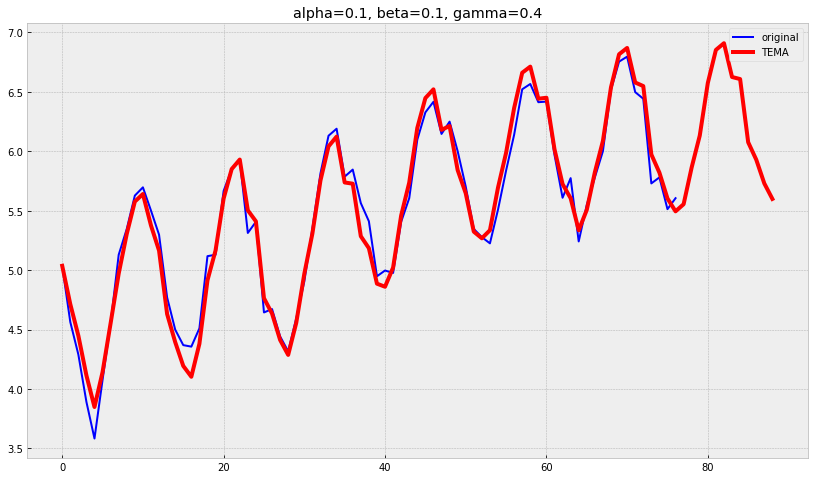

In [316]:
n = 12
plot_tema(0.1, 0.1, 0.4, series, series, n)

Наблюдения:
1) при гамма стремщейся к 1 график стремиться повторить исходный ряд;
2) с ростом периода прогнозирвания тренд начинается заваливатсья и очень напоминает график экспоненты;
3) гамма почти не влияет на график - вероятно сезонность в этом яде отсутсвует.

#### Дифференцированный ряд

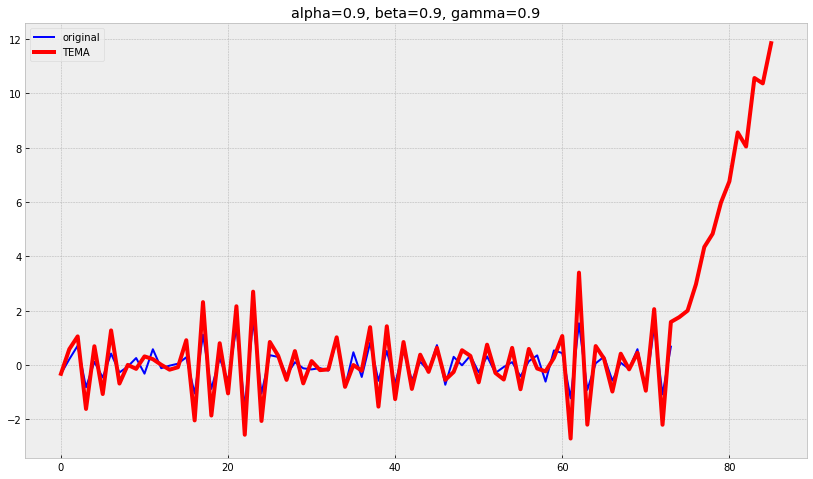

In [317]:
n = 12
plot_tema(0.9, 0.9, 0.9, series_dif, n)

Наблюдения:
1) наблюдается заметное расходение в начале ряда;
2) при малых значениях коэффициетов график усиливает "малые экстремумы", и ослаблает "большие" - как бы усредняя исходный график;
3) при больших значениях коэффициентов прогноз устремляется в небо.

## Подбор параметров

In [318]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [319]:
def mse_trs(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    
    return error

In [320]:
def mse_dema(X):
    alpha, beta, gamma = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    
    return error

#### Исходный ряд

In [321]:
train, test, val = series[:60], series[60:70], series[70:]

##### Хольт-Винтерс

In [322]:
opt = minimize(mse_trs, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.045479576733163773
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.64985819e-07,  1.67574288e-06, -3.73636538e-03])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 76
      nit: 16
   status: 0
  success: True
        x: array([0.90480301, 0.05139982, 1.        ])


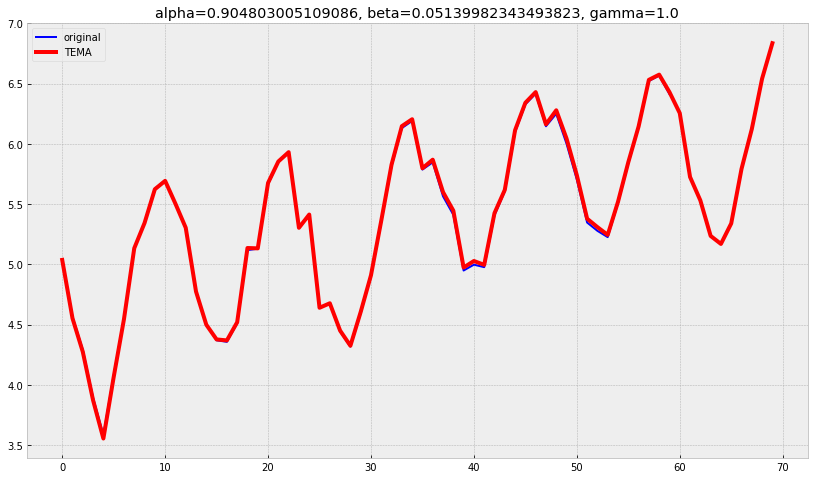

In [323]:
plot_tema(alpha_opt, beta_opt, gamma_opt, train, series[:70], n_preds=len(test))

##### Двойное экспоненциальное сглаживание

In [324]:
opt = minimize(mse_dema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.03817032052671039
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.71445147e-09, -2.49800181e-08,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 124
      nit: 21
   status: 0
  success: True
        x: array([0.33036464, 0.2252656 , 0.        ])


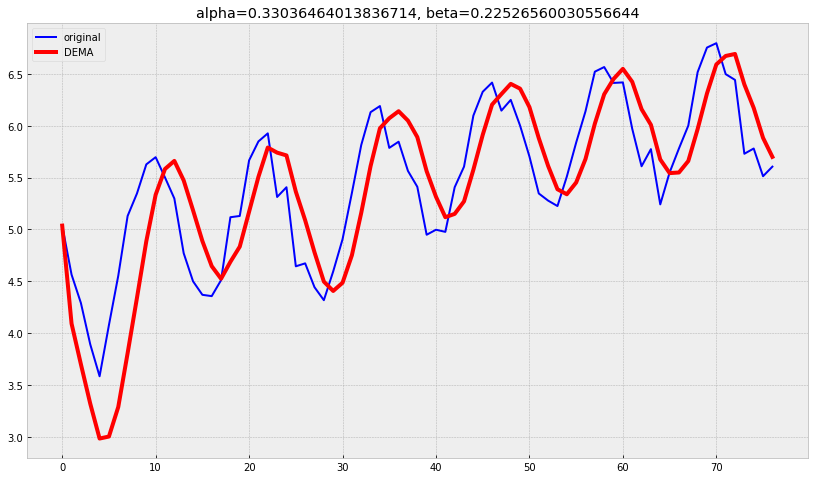

In [325]:
#просто решил посмотеть, что будет
plot_dema(series, alpha_opt, beta_opt)

#### Дифференцированный ряд

In [326]:
train, test, val = series_dif[:60], series_dif[60:70], series_dif[70:]

##### Хольт-Винтерс

In [327]:
opt = minimize(mse_trs, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.65562514907951
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.25948141e-03, -1.57873714e-05,  5.70305247e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 392
      nit: 60
   status: 0
  success: True
        x: array([0.00774224, 0.63077486, 0.        ])


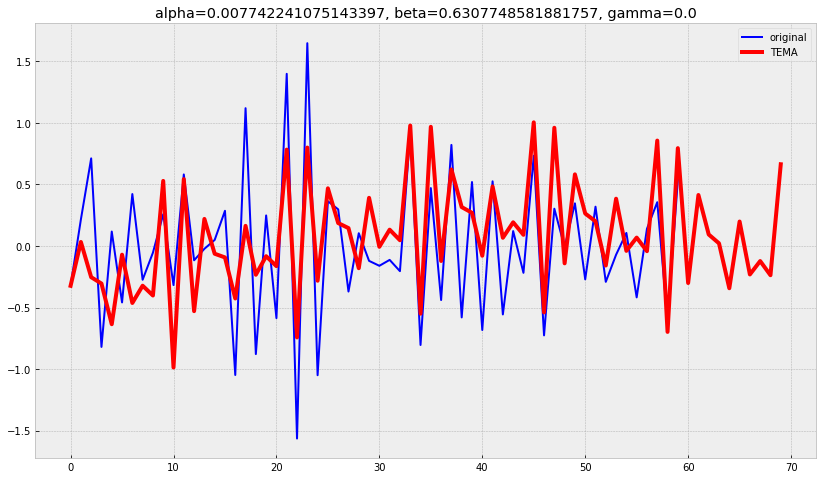

In [328]:
plot_tema(alpha_opt, beta_opt, gamma_opt, train, series_dif[:70], n_preds=len(test))

##### Двойное экспоненциальное сглаживание

In [329]:
opt = minimize(mse_dema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.5731319572925387
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.99200722e-07, -2.55351296e-06,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 144
      nit: 29
   status: 0
  success: True
        x: array([0.11257755, 0.14420567, 0.        ])


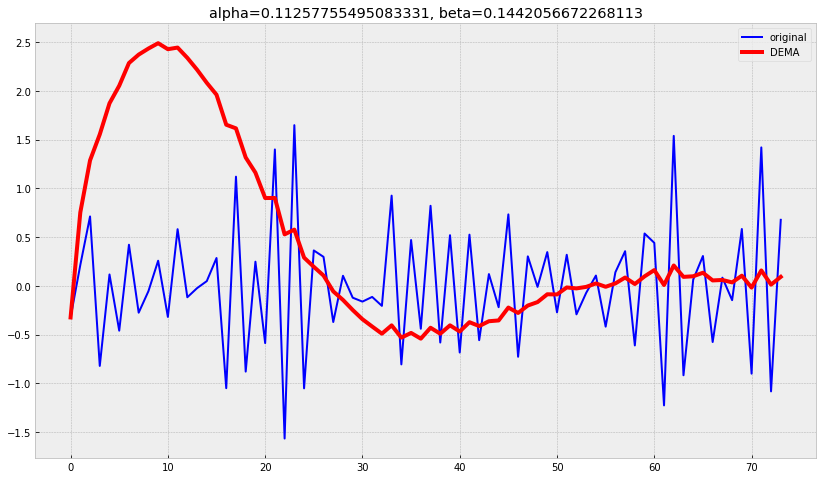

In [330]:
#просто решил посмотеть, что будет
plot_dema(series_dif, alpha_opt, beta_opt)

Похоже на обработанном ряде прогноз выглядит более адекватным.